ML4HC_Project01_Code:
Part 2


In [8]:
# import packages
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, transforms, models

import matplotlib.pyplot as plt
import numpy as np
import os

In [9]:
#install kaggle
! pip install kaggle

In [10]:
# mount drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
# make tmp kaggle folder, add json, allow
! mkdir ~/.kaggle
! cp /content/drive/MyDrive/ETH/kaggle/kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [12]:
# download and unzip dataset
! kaggle datasets download paultimothymooney/chest-xray-pneumonia
! unzip chest-xray-pneumonia.zip

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  inflating:

In [13]:
#load dataset paths
#have to store lables here..
data_dir = '/content/chest_xray/train/NORMAL/'
train_normal = [name for name in os.listdir(data_dir) if os.path.splitext(name)[-1] == '.jpeg']
train_normal = [data_dir + path for path in train_normal]
data_dir = '/content/chest_xray/train/PNEUMONIA/'
train_pneumonia = [name for name in os.listdir(data_dir) if os.path.splitext(name)[-1] == '.jpeg']
train_pneumonia = [data_dir + path for path in train_pneumonia]
train = train_normal + train_pneumonia

data_dir = '/content/chest_xray/val/NORMAL/'
val_normal = [name for name in os.listdir(data_dir) if os.path.splitext(name)[-1] == '.jpeg']
val_normal = [data_dir + path for path in val_normal]
data_dir = '/content/chest_xray/val/PNEUMONIA/'
val_pneumonia = [name for name in os.listdir(data_dir) if os.path.splitext(name)[-1] == '.jpeg']
val_pneumonia = [data_dir + path for path in val_pneumonia]
val = val_normal + val_pneumonia

data_dir = '/content/chest_xray/test/NORMAL/'
test_normal = [name for name in os.listdir(data_dir) if os.path.splitext(name)[-1] == '.jpeg']
test_normal = [data_dir + path for path in test_normal]
data_dir = '/content/chest_xray/test/PNEUMONIA/'
test_pneumonia = [name for name in os.listdir(data_dir) if os.path.splitext(name)[-1] == '.jpeg']
test_pneumonia = [data_dir + path for path in test_pneumonia]
test = test_normal + test_pneumonia

In [14]:
# to normalize to [0,1]
class normalize(object):
    def __call__(self, sample):
        image, label = sample
        return image.float() / torch.max(image), label #devide by max pixel

def get_data(path):
    # def transforms
    transform = transforms.Compose([
        transforms.Resize((512, 512)),  # resize
        transforms.ToTensor(),           # to PyTorch tensors
        #normalize()                        # normalize to [0, 1] >> information in absolut value
    ])

    # load dataset with transforms
    dataset = datasets.ImageFolder(root=path, transform=transform)

    # make dataLoader with batch_size = 32
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

    # print labels and images
    #for images, labels in dataloader:
    #    print(images.shape)
    #    print(labels)

    return dataloader

In [56]:
# loading dataset
train = get_data('/content/chest_xray/train')
val = get_data('/content/chest_xray/val')
test = get_data('/content/chest_xray/test')

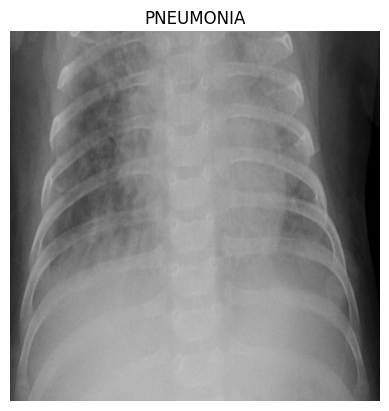

In [16]:
## Plotting one example
# get next image
images, labels = next(iter(train))

# to numpy
image = images[0].numpy()
label = labels[0].item()

# convert tensor shape (channels, height, width) to (height, width, channels)
image = np.transpose(image, (1, 2, 0))

# def classes
classes = ['NORMAL', 'PNEUMONIA']

# plot
plt.imshow(image)
plt.title(classes[label])
plt.axis('off')
plt.show()

In [17]:
# descriptive stats

In [18]:
## Setup model
# load  pre-trained ResNet model
model = models.resnet50(pretrained=True)

# freeze grad
for param in model.parameters():
    param.requires_grad = False

# add last linear layer with two outcomes
model.fc = nn.Linear(model.fc.in_features, 2)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 107MB/s]


In [ ]:
# train the model
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")


In [ ]:
torch.save(model.state_dict(), 'trained_model_1146.pth')
#model_save_name = 'resnet50_model_trained.pt'
#path = F"/content/gdrive/'My Drive'/{model_save_name}"
#torch.save(model.state_dict(), path)

In [40]:
# Evaluate the model on the validation set
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in val:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f"Validation Accuracy: {accuracy:.4f}")

Validation Accuracy: 0.5000


In [50]:
images, labels = next(iter(val))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model(images.to(device))

tensor([[0.7746, 0.2145],
        [0.5348, 0.0516],
        [0.8153, 0.1193],
        [0.6613, 0.1701],
        [0.8009, 0.2171],
        [0.7265, 0.1242],
        [0.6771, 0.1903],
        [0.6553, 0.2429],
        [0.5935, 0.2560],
        [0.9641, 0.0644],
        [0.6871, 0.2515],
        [0.7664, 0.2021],
        [0.6385, 0.1612],
        [0.7006, 0.1953],
        [0.6724, 0.3177],
        [0.8201, 0.3178]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [25]:
# comparison against state of the art pneumonia model
#from chexnet_model import CheXNet
#model_chexnet = CheXNet()

In [37]:
def train_epoch(net, dataloader, device=torch.device("cuda" if torch.cuda.is_available() else "cpu"), lr=0.001, optimiser=None, loss_fn = nn.CrossEntropyLoss()):
    optimiser = optimiser or torch.optim.Adam(net.parameters(), lr=lr)
    # Ensure the network is in training mode
    net.to(device)
    net.train()
    total_loss, acc, count = 0,0,0
    for features,labels in dataloader:
        # Ensure features/images and labels are on the correct device
        features, labels = features.to(device), labels.to(device)
        # Predict outputs for features and compute the loss between predictions
        # and labels
        out = net(features)
        loss = loss_fn(out, labels)
        total_loss += loss

        # Zero gradients from earlier computations
        optimiser.zero_grad()
        # Compute gradients for weights
        loss.backward()
        # Do optimiser step
        optimiser.step()

        # Get predicted classes as the entry with the highest probability
        _, predicted = torch.max(out, 1)
        # Compute accuracy
        acc += (predicted == labels).sum().cpu()
        count += len(labels)
    return total_loss.item()/count, acc.item()/count

In [35]:
def validate_epoch(net, dataloader, device=torch.device("cuda" if torch.cuda.is_available() else "cpu"), loss_fn=nn.CrossEntropyLoss()):
    # Ensure network is in evaluation mode
    net.to(device)
    net.eval()
    count,acc,loss = 0,0,0
    # We use torch.no_grad() to remove gradient computations
    # This is not necessary, but can be much faster
    with torch.no_grad():
        for features,labels in dataloader:
            # Ensure features and labels are on the correct device
            features = features.to(device)
            labels = labels.to(device)
            # Make predictions
            out = net(features)
            # Compute loss and accuracy of the model
            loss += loss_fn(out,labels)
            pred = torch.max(out,1)[1]
            acc += (pred==labels).sum()
            count += len(labels)
    return loss.item()/count, acc.item()/count

validate_epoch(model, val, device)

(0.04508469998836517, 0.4375)

Overfitting?

In [38]:
#access overfitting
def train(net, train_loader, test_loader, device=torch.device("cuda" if torch.cuda.is_available() else "cpu"), optimiser=None, lr=0.001, epochs=10, loss_fn=nn.CrossEntropyLoss()):
    optimiser = optimiser or torch.optim.Adam(net.parameters(),lr=lr)
    res = { 'train_loss' : [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    net.to(device)
    for ep in range(epochs):
        tl,ta = train_epoch(
            net=net,
            dataloader=train_loader,
            device=device,
            optimiser=optimiser, lr=lr, loss_fn=loss_fn)
        vl,va = validate_epoch(
            net=net,
            dataloader=test_loader,
            device=device,
            loss_fn=loss_fn)
        print(f"Epoch {ep:2}, Train acc={ta:.3f}, Val acc={va:.3f}, Train loss={tl:.3f}, Val loss={vl:.3f}")
        res['train_loss'].append(tl)
        res['train_acc'].append(ta)
        res['val_loss'].append(vl)
        res['val_acc'].append(va)
    return res

# Re-initialize the network to start from scratch
# load  pre-trained ResNet model
net = models.resnet50(pretrained=True)
# freeze grad
for param in model.parameters():
    param.requires_grad = False
# add last linear layer
model.fc = nn.Linear(model.fc.in_features, 2)

# This will take a minute or two
hist = train(
    net=net,
    train_loader=train,
    test_loader=val,
    device=device,
    epochs=10
)


TypeError: 'function' object is not iterable

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(hist['train_acc'], label='Training acc')
plt.plot(hist['val_acc'], label='Validation acc')
plt.legend()
plt.subplot(122)
plt.plot(hist['train_loss'], label='Training loss')
plt.plot(hist['val_loss'], label='Validation loss')
plt.legend()

Integrated Gradients

Grad-CAM

https://github.com/jacobgil/pytorch-grad-cam

In [28]:
!pip install grad-cam
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 46.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  U

In [54]:
target_layers = [model.layer4[-1]]
images, labels = next(iter(val))
input_tensor = images
# Note: input_tensor can be a batch tensor with several images!

# Construct the CAM object once, and then re-use it on many images:
cam = GradCAM(model=model, target_layers=target_layers)

targets = [ClassifierOutputTarget(2)]

# You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)

# In this example grayscale_cam has only one image in the batch:
grayscale_cam = grayscale_cam[0, :]
visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

# You can also get the model outputs without having to re-inference
model_outputs = cam.outputs


IndexError: index 2 is out of bounds for dimension 0 with size 2

Data Randomization Test